# Import libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import make_classification, make_regression

# Data preparation
We are going to create artificial datasets for illustration purposes.

In [2]:
n_samples = 50000
n_features = 50
n_informative = 25

feature_names = [f'Feature_{i+1}' for i in range(n_features)]

# I. [Easy use] - Use already wrapped XGBoost models
_____________________________________________________

You can use XGBoost models that are already conveniently wrapped with Wrapshap. If you want to run Wrapshap on your own model (any model type as long as you were able to compute its SHAP values), please refer to the section II.

## 1. CPU implementation

In [4]:
from wrapshap.already_wrapped import WrappedBinaryClassifierXGB, WrappedRegressorXGB

### a. Quick binary classification example

Artificial dataset generation:

In [5]:
X_classif, y_classif = make_classification(n_samples=n_samples, n_features=n_features,
                                       n_informative=n_informative, random_state=42, shuffle=False)

Instantiate the already-wrapped XGBoost model:

In [6]:
wrapped_classifier = WrappedBinaryClassifierXGB(
    X=X_classif,
    y=y_classif,
    feature_names=feature_names,
    # test_size=0.2,      # default value
    # random_state=42,    # default value
    # encode_label=True   # default value
    # **kwargs          # you can add any XGBoost parameters here ie. learning_rate=0.01, tree_method='gpu_hist', ...
) 

You can fit the model and compute its SHAP values and predictions:

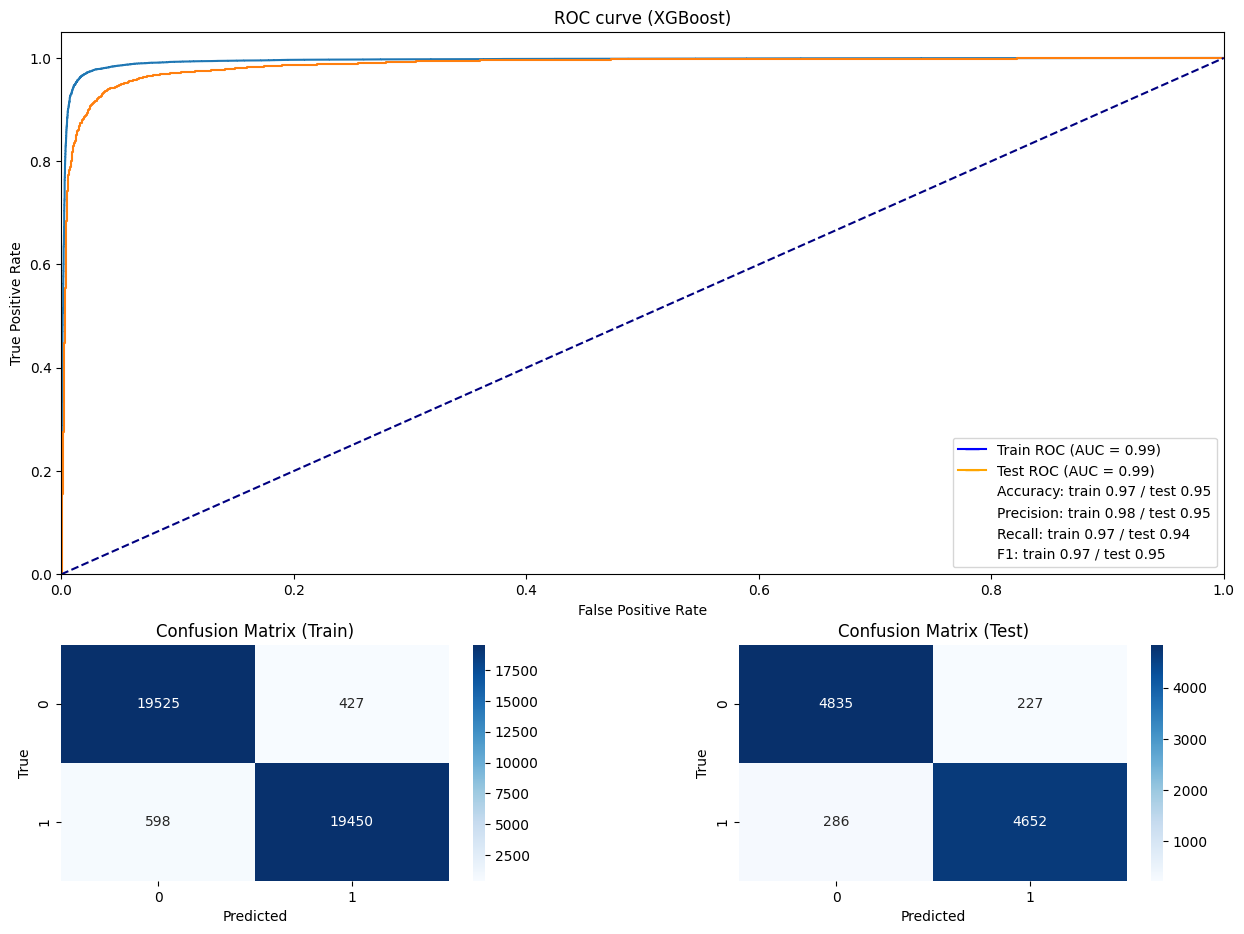

In [7]:
wrapped_classifier.fit(
    # scale_pos_weight=False,     # default value
    # eval_size=0.2,              # default value
    # num_boost_round=10000,      # default value, because we use early stopping
    # early_stopping_rounds=10,   # default value
    # verbose_eval=False,         # default value
    # threshold_prob=0.5          # default value
)

# wrapped_classifier.plot_performance() # you can plot the model performance at any time

wrapped_classifier.compute_shap_and_predictions()

You can display the SHAP Summary Plot:

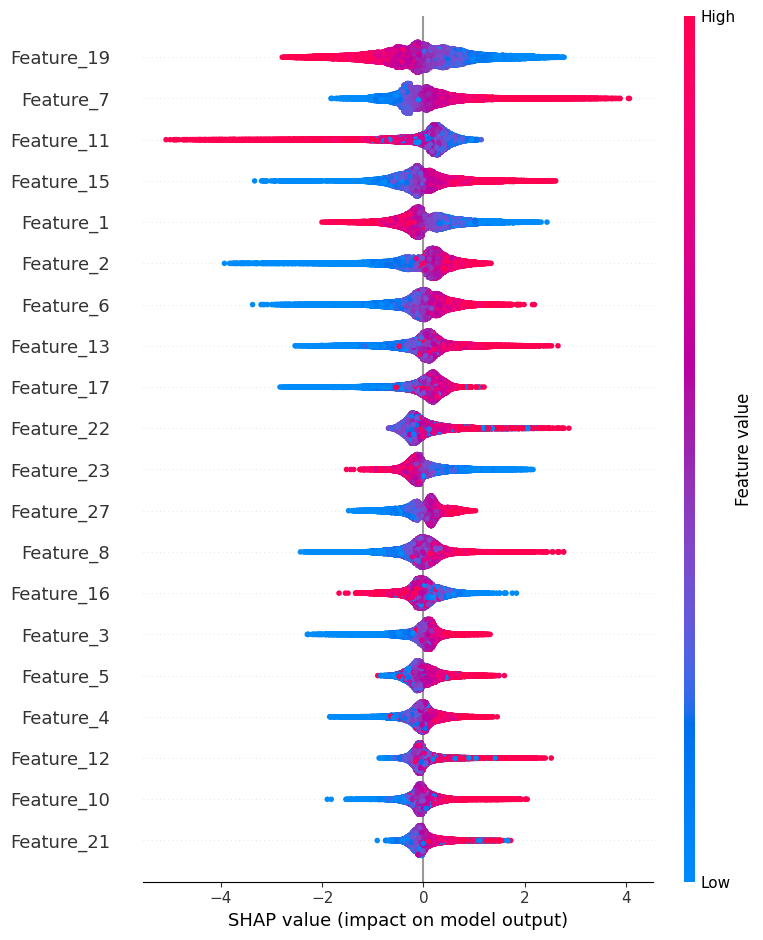

In [8]:
wrapped_classifier.shap_summary_plot(
    # return_ranking=False,     # default value
    # max_display=None          # default value
)

You can run Wrapshap methods. In the CPU implementation, 3 methods are available:
- `shapRFE`
- `shapBFE`
- `shapFFS`

Important: `shapBFE` and `shapFFS` might take long to compute on CPU for big datasets. Consider the GPU implementation in this case. Another option that is available with all Wrapshap methods is to set the `top` parameter to restrain the number of features being considered. With `top`= `15`, only the 15 features with biggest mean absolute SHAP values will be considered.

In [9]:
ranking_rfe, perfs_rfe = wrapped_classifier.shapRFE(
    # surrogate_metrics=False,    # default value
    # top=None                    # default value
)

Progress: |██████████████████████████████████████████████████| 50/50 Complete


In [10]:
ranking_ffs, perfs_ffs = wrapped_classifier.shapFFS(
    # surrogate_metrics=False,    # default value
    # top=None                    # default value
)

Progress: |██████████████████████████████████████████████████| 50/50 Complete


In [11]:
ranking_bfe, perfs_bfe = wrapped_classifier.shapBFE(
    # surrogate_metrics=False,    # default value
    # top=None                    # default value
)

Progress: |██████████████████████████████████████████████████| 50/50 Complete


If you forgot to set `surrogate_metrics`=`True`, you can always pass the ranking of your choice to `get_surrogate_metrics` to retrieve them:

In [12]:
perfs_rfe = wrapped_classifier.get_surrogate_metrics(
    feature_ranking=ranking_rfe,
    metrics_dict=perfs_rfe
)

Progress: |██████████████████████████████████████████████████| 50/50 Complete (surrogate metrics computation)


### b. Regression example

The process remains the same for a regression scenario.

Let's generate an artificial dataset for illustration purposes:

In [17]:
X_reg, y_reg = make_regression(n_samples=n_samples, n_features=n_features,
                                       n_informative=n_informative, noise=0.1, random_state=42, shuffle=False)

Let's proceed similarly:

In [18]:
wrapped_regressor = WrappedRegressorXGB(
    X=X_reg,
    y=y_reg,
    feature_names=feature_names
)

If you don't call `fit` and `compute_shap_and_predictions` before calling a function requiring SHAP values, it will be done automatically with default parameters:

No model found.
Fitting model with default parameters..


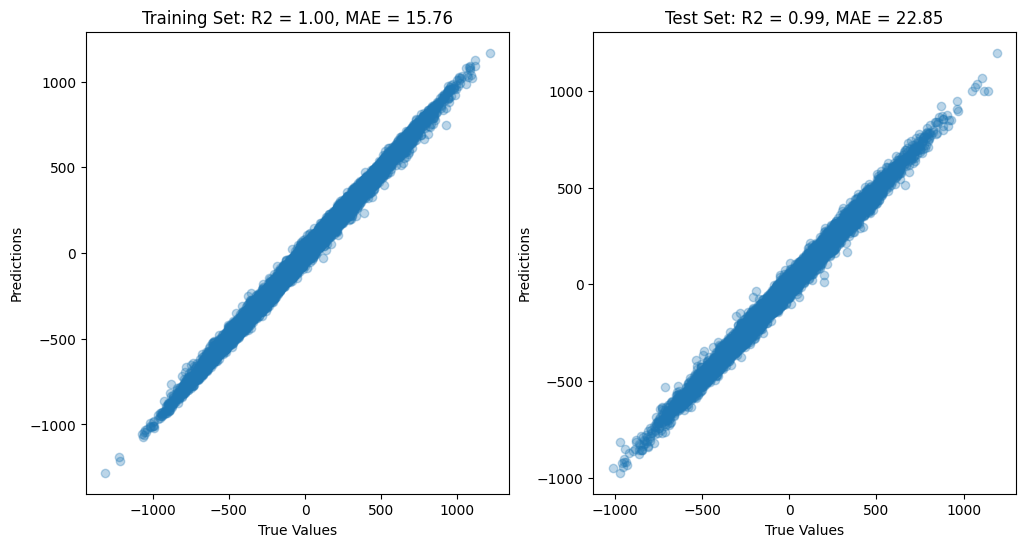

Done.
Computing SHAP values and predictions..
Done.
Progress: |██████████████████████████████████████████████████| 50/50 Complete
Progress: |██████████████████████████████████████████████████| 50/50 Complete
Progress: |██████████████████████████████████████████████████| 50/50 Complete


In [19]:
ranking_rfe, perfs_rfe = wrapped_regressor.shapRFE()
ranking_rbe, perfs_bfe = wrapped_regressor.shapBFE()
ranking_ffs, perfs_ffs = wrapped_regressor.shapFFS()

## 2. GPU implementation

If you can afford it, the GPU implementation is faster and provides more methods. 

We will only illustrate regression here, but everything is similar for binary classification.

In [21]:
from wrapshap.gpu_implementation.already_wrapped_gpu import WrappedRegressorXGB_GPU #, WrappedBinaryClassifierXGB_GPU

Proceed similarly as with the CPU implementation:

In [22]:
X_reg, y_reg = make_regression(n_samples=n_samples, n_features=n_features,
                                       n_informative=n_informative, noise=0.1, random_state=42, shuffle=False)

In [23]:
gpu_wrapped_regressor = WrappedRegressorXGB_GPU(
    X=X_reg,
    y=y_reg,
    feature_names=feature_names
)

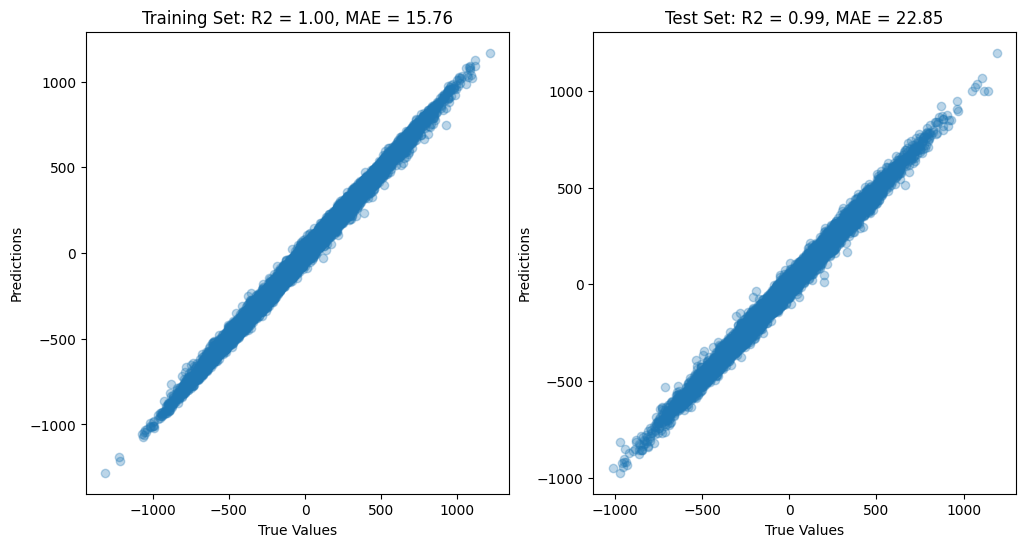

In [24]:
gpu_wrapped_regressor.fit()
gpu_wrapped_regressor.compute_shap_and_predictions()

The GPU implementation provides the following methods:
- `shapRFE`
- `shapFFS`
- `shapBFE`
- `shapNCK`
- `shapXFFS`

In [26]:
gpu_rfe_ranking, gpu_rfe_perfs = gpu_wrapped_regressor.shapRFE()
gpu_bfe_ranking, gpu_bfe_perfs = gpu_wrapped_regressor.shapBFE()
gpu_ffs_ranking, gpu_ffs_perfs = gpu_wrapped_regressor.shapFFS()

Progress: |██████████████████████████████████████████████████| 50/50 Complete
Progress: |██████████████████████████████████████████████████| 50/50 Complete
Progress: |██████████████████████████████████████████████████| 50/50 Complete


Instead of removing or adding feature iteratively, `shapNCK` tests all possible combinations of `k` features out of all `n` features and return the best one. Because of the exhaustivity of the search, computation time increases dramatically as `k` is greater than 2 or 3 (depending on the dataset size).

In [27]:
best_combination, all_scores, all_combinations = gpu_wrapped_regressor.shapNCK(k=3)

Performing 19600 linear regressions
Processed batch 1/40
Processed batch 2/40
Processed batch 3/40
Processed batch 4/40
Processed batch 5/40
Processed batch 6/40
Processed batch 7/40
Processed batch 8/40
Processed batch 9/40
Processed batch 10/40
Processed batch 11/40
Processed batch 12/40
Processed batch 13/40
Processed batch 14/40
Processed batch 15/40
Processed batch 16/40
Processed batch 17/40
Processed batch 18/40
Processed batch 19/40
Processed batch 20/40
Processed batch 21/40
Processed batch 22/40
Processed batch 23/40
Processed batch 24/40
Processed batch 25/40
Processed batch 26/40
Processed batch 27/40
Processed batch 28/40
Processed batch 29/40
Processed batch 30/40
Processed batch 31/40
Processed batch 32/40
Processed batch 33/40
Processed batch 34/40
Processed batch 35/40
Processed batch 36/40
Processed batch 37/40
Processed batch 38/40
Processed batch 39/40
Processed batch 40/40

Best R2 Score: 0.30864888
Best Feature Combination: ('Feature_8', 'Feature_15', 'Feature_22'

Finally, `shapXFFS` is a variant of `shapFFS` in which instead of selecting the best feature at each step, you consider the `n` best features at each step and continue building the `n` trees from there. It is a convenient tool to explore colinearities.

In [28]:
tree = gpu_wrapped_regressor.shapXFFS(
    n=3,
    max_depth=4,
    # top=None      # default value
)

Such tree is a python dict but can be visualized with `print_XFFS_tree`:

In [29]:
from wrapshap.gpu_implementation import print_XFFS_tree

print_XFFS_tree(
    tree=tree,
    # metric='train_pred_r2',       # default value
    # export_to_txt=False,          # default value
    # filename='tree.txt',          # default value
    # hide_duplicates=False         # default value
)

Displayed metric: train_pred_r2

1 --> Feature_15 (0.11)
    2 --> Feature_8 (0.21)
        3 --> Feature_22 (0.31)
            4 --> Feature_7 (0.39)
            4 --> Feature_11 (0.39)
            4 --> Feature_1 (0.39)
        3 --> Feature_7 (0.3)
            4 DUPLICATE --> Feature_22 (0.39)
            4 --> Feature_11 (0.38)
            4 --> Feature_1 (0.37)
        3 --> Feature_11 (0.29)
            4 DUPLICATE --> Feature_22 (0.39)
            4 DUPLICATE --> Feature_7 (0.38)
            4 --> Feature_1 (0.37)
    2 --> Feature_22 (0.21)
        3 DUPLICATE --> Feature_8 (0.31)
        3 --> Feature_7 (0.29)
            4 DUPLICATE --> Feature_8 (0.39)
            4 --> Feature_11 (0.37)
            4 --> Feature_1 (0.37)
        3 --> Feature_11 (0.29)
            4 DUPLICATE --> Feature_8 (0.39)
            4 DUPLICATE --> Feature_7 (0.37)
            4 --> Feature_1 (0.37)
    2 --> Feature_7 (0.2)
        3 DUPLICATE --> Feature_8 (0.3)
        3 DUPLICATE --> Feature_22

# II. [Normal use] - Use Wrapshap with your own model
_____________________________________________________

## 1. CPU implementation

The only difference with the already wrapped XGBoost models option is that you have to compute your model's SHAP values and predictions yourself.

Precisely, Wrapshap requires you to provide the following data:
- `X_train`: the original train set (as a 2D array)
- `X_test`: the original test set (as a 2D array)
- `y_train`: the original train target (as a 1D array)
- `y_test`: the original test target (as a 1D array)
- `shap_train`: the SHAP values for the train set (as a 2D array)
- `shap_test`: the SHAP values for the test set (as a 2D array)
- `y_pred_train`: the raw predictions of your model on the train set (as a 1D array)
- `y_pred_test`: the raw predictions of your model on the set set (as a 1D array)

We will compute such data with a dummy binary classification model for illustration purposes:

In [30]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

X_classif, y_classif = make_classification(n_samples=n_samples, n_features=n_features,
                                       n_informative=n_informative, random_state=42, shuffle=False)

feature_names = [f"Feature_{i}" for i in range(1, X_classif.shape[1]+1)]

X_train, X_test, y_train, y_test = train_test_split(X_classif, y_classif, test_size=0.2)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

model = xgb.train(
    params={},
    dtrain=dtrain,
)

shap_train = model.predict(dtrain, pred_contribs=True)[:,:-1] # remove the last element, base value
shap_test = model.predict(dtest, pred_contribs=True)[:,:-1]

y_pred_train = model.predict(dtrain, output_margin=True) # we need raw predictions (log-odds), not probabilities 
y_pred_test = model.predict(dtest, output_margin=True)

Once you have your data, you can import and instantiate the `Wrapshap` object:

In [31]:
from wrapshap import Wrapshap

wrap = Wrapshap(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    shap_train=shap_train,
    shap_test=shap_test,
    y_pred_train=y_pred_train,
    y_pred_test=y_pred_test,
    feature_names=feature_names,
    task_type='classification'
)

You know have access to all the regular Wrapshap functions:
- `shapRFE`
- `shapBFE`
- `shapFFS`

And utilities:
- `get_surrogate_metrics`
- `shap_summary_plot`

In [32]:
rfe_ranking, rfe_perfs = wrap.shapRFE()
bfe_ranking, bfe_perfs = wrap.shapBFE()
ffs_ranking, ffs_perfs = wrap.shapFFS()

Progress: |██████████████████████████████████████████████████| 50/50 Complete
Progress: |██████████████████████████████████████████████████| 50/50 Complete
Progress: |██████████████████████████████████████████████████| 50/50 Complete


## 2. GPU implementation

The GPU implementation is very similar. It simply provides the additional methods `shapNCK` and `shapXFFS` as well as allows for faster computation of `shapBFE` and `shapFFS`.

In [33]:
from wrapshap.gpu_implementation import WrapshapGPU#, print_XFFS_tree

gpu_wrap = WrapshapGPU(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    shap_train=shap_train,
    shap_test=shap_test,
    y_pred_train=y_pred_train,
    y_pred_test=y_pred_test,
    feature_names=feature_names,
    task_type='classification'
)

In [34]:
gpu_rfe_ranking, gpu_rfe_perfs = gpu_wrap.shapRFE()
gpu_bfe_ranking, gpu_bfe_perfs = gpu_wrap.shapBFE()
gpu_ffs_ranking, gpu_ffs_perfs = gpu_wrap.shapFFS()

Progress: |██████████████████████████████████████████████████| 50/50 Complete
Progress: |██████████████████████████████████████████████████| 50/50 Complete
Progress: |██████████████████████████████████████████████████| 50/50 Complete


In [35]:
best_combination, all_scores, all_combinations = gpu_wrap.shapNCK(k=3)

Performing 19600 linear regressions
Processed batch 1/40
Processed batch 2/40
Processed batch 3/40
Processed batch 4/40
Processed batch 5/40
Processed batch 6/40
Processed batch 7/40
Processed batch 8/40
Processed batch 9/40
Processed batch 10/40
Processed batch 11/40
Processed batch 12/40
Processed batch 13/40
Processed batch 14/40
Processed batch 15/40
Processed batch 16/40
Processed batch 17/40
Processed batch 18/40
Processed batch 19/40
Processed batch 20/40
Processed batch 21/40
Processed batch 22/40
Processed batch 23/40
Processed batch 24/40
Processed batch 25/40
Processed batch 26/40
Processed batch 27/40
Processed batch 28/40
Processed batch 29/40
Processed batch 30/40
Processed batch 31/40
Processed batch 32/40
Processed batch 33/40
Processed batch 34/40
Processed batch 35/40
Processed batch 36/40
Processed batch 37/40
Processed batch 38/40
Processed batch 39/40
Processed batch 40/40

Best R2 Score: 0.55618393
Best Feature Combination: ('Feature_11', 'Feature_16', 'Feature_19

In [36]:
tree = gpu_wrap.shapXFFS(n=3, max_depth=4)
print_XFFS_tree(tree)

Displayed metric: train_pred_r2

1 --> Feature_19 (0.32)
    2 --> Feature_11 (0.45)
        3 --> Feature_16 (0.56)
            4 --> Feature_7 (0.64)
            4 --> Feature_13 (0.63)
            4 --> Feature_5 (0.63)
        3 --> Feature_13 (0.55)
            4 DUPLICATE --> Feature_16 (0.63)
            4 --> Feature_6 (0.62)
            4 --> Feature_12 (0.62)
        3 --> Feature_5 (0.54)
            4 DUPLICATE --> Feature_16 (0.63)
            4 --> Feature_13 (0.62)
            4 --> Feature_6 (0.62)
    2 --> Feature_13 (0.43)
        3 DUPLICATE --> Feature_11 (0.55)
        3 --> Feature_6 (0.52)
            4 DUPLICATE --> Feature_11 (0.62)
            4 --> Feature_12 (0.6)
            4 --> Feature_5 (0.6)
        3 --> Feature_17 (0.52)
            4 --> Feature_11 (0.61)
            4 --> Feature_6 (0.59)
            4 --> Feature_12 (0.59)
    2 --> Feature_5 (0.43)
        3 DUPLICATE --> Feature_11 (0.54)
        3 --> Feature_6 (0.52)
            4 --> Feature